Exploration manipulation produit sentinel 1 avec rasterio

In [12]:
import rasterio as rio
import pandas
import geopandas as gpd
import numpy as np
from pathlib import Path
from eoreader.reader import Reader
from eoreader.bands import *
import pprint as pp
import rioxarray as rioxr
import os
import xarray as xr

In [13]:
from src.io.load import load_shapefile
from src.config import ConfigS1 as cfg

In [14]:
root_data_path = "/home/rustt/Documents/Projects/S1_S2_classification/Data"

raster_path_zip = str(Path(root_data_path) / "Tests/zip" / "S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.zip")
raster_path = str(Path(root_data_path) / "Tests/zip" / "S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE")
raster_path_tif = str(Path(root_data_path) / "Tests" / "s1b-iw-grd-vh-20170425t214234-20170425t214302-005323-00953e-002.tiff")
raster_file_tif = "s1b-iw-grd-vh-20170425t214234-20170425t214302-005323-00953e-002.tiff"

In [37]:
with rio.open(raster_path) as src:
    print(src.crs)
    print(src.bounds)
    print(src.height)
    print(src.width)
    print(src.transform)
    profile = src.profile
    meta = src.meta
    pp.pprint(src.tags())
    raster = src.read(1)
    print(src.descriptions)
    overview_factors = [src.overviews(i) for i in src.indexes]


None
BoundingBox(left=0.0, bottom=19094.0, right=25167.0, top=0.0)
19094
25167
| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
{'ACQUISITION_START_TIME': '2017-04-25T21:42:34.373420',
 'ACQUISITION_STOP_TIME': '2017-04-25T21:43:02.748930',
 'BEAM_MODE': 'IW',
 'BEAM_SWATH': 'IW',
 'FACILITY_IDENTIFIER': 'Copernicus S1 Core Ground Segment - DPA',
 'LINE_SPACING': '1.000000e+01',
 'MISSION_ID': 'S1B',
 'MODE': 'IW',
 'ORBIT_DIRECTION': 'ASCENDING',
 'ORBIT_NUMBER': '5323',
 'PIXEL_SPACING': '1.000000e+01',
 'PRODUCT_TYPE': 'GRD',
 'SATELLITE_IDENTIFIER': 'SENTINEL-1',
 'SENSOR_IDENTIFIER': 'SAR',
 'SWATH': 'IW'}
(None, None)


RASTER PAS GEOREFERENCE AVEC OUVERTURE RASTERIO

## Georeferencing

* Extract coordinates

In [8]:
area_geom = load_shapefile(cfg.area_path)

In [9]:
area_geom.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Georeferencing with WarpedVRT

In [15]:
from rasterio.vrt import WarpedVRT
from rasterio import shutil as rio_shutil
from rasterio.enums import Resampling

outfile = "../../Data/Tests/rds_clip.tif"

with rioxr.open_rasterio(raster_path) as fp:
    global_attrs = fp.attrs

# get polarisation and dataarray attributes into dict mapping

area_geom = load_shapefile(cfg.area_path)
min_lon, min_lat, max_lon, max_lat = area_geom.geometry.values[0].bounds

with rio.open(raster_path_tif) as rs_src:
    gcps, crs_gcps = rs_src.gcps
    params_vrt = {
        "src_crs":crs_gcps,
        "src_transform":rio.transform.from_gcps(gcps),
        'resampling': Resampling.cubic,
    }
    with WarpedVRT(rs_src, **params_vrt) as vrt:

        rs = rioxr.open_rasterio(vrt)
        rs_clip = rs.rio.clip_box(minx=min_lon, 
                      miny=min_lat, 
                      maxx=max_lon, 
                      maxy=max_lat)
        
        rs_clip = rs_clip.assign_attrs(global_attrs)
        rs_clip.rio.to_raster(outfile)
        #rio_shutil.copy(vrt, outfile, driver='GTiff')

In [97]:
rs_clip

<xarray.DataArray (band: 1, y: 4000, x: 5554)>
[22216000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -52.68 -52.68 -52.68 ... -52.18 -52.18 -52.18
  * y            (y) float64 5.156 5.156 5.156 5.156 ... 4.793 4.793 4.793 4.793
    spatial_ref  int64 0
Attributes: (12/17)
    scale_factor:            1.0
    add_offset:              0.0
    ACQUISITION_START_TIME:  2017-04-25T21:42:34.373420
    ACQUISITION_STOP_TIME:   2017-04-25T21:43:02.748930
    BEAM_MODE:               IW
    BEAM_SWATH:              IW
    ...                      ...
    ORBIT_NUMBER:            5323
    PIXEL_SPACING:           10.0
    PRODUCT_TYPE:            GRD
    SATELLITE_IDENTIFIER:    SENTINEL-1
    SENSOR_IDENTIFIER:       SAR
    SWATH:                   IW

### Geo-referencing with rioxarray

In [17]:
rds_folder = rioxr.open_rasterio(raster_path, parse_coordinates=True)
#rds = rioxr.open_rasterio(outfile)

In [64]:
transformer = rio.transform.GCPTransformer(gcps)
pt = transformer.xy(0, 0)

In [110]:
rows, cols = rds_folder.sizes['y'], rds_folder.sizes['x']
indices = max(rows, cols)
coordinates = transformer.xy(range(indices), range(indices))

In [18]:
outfile = '../../Data/Tests/rds_geo_rioxr.tif'

with rioxr.open_rasterio(raster_path) as rds_folder:
    cols, rows = rds_folder.sizes['y'], rds_folder.sizes['x']
    indices = max(rows, cols)# transformer works on same col/rows lengths
    
    transformer = rio.transform.GCPTransformer(gcps)
    transform = rio.transform.from_gcps(gcps)
    lon_list, lat_list = transformer.xy(range(indices), range(indices))

    ampl = rds_folder.AMPLITUDE
    ampl_b1 = ampl.sel(band=1).data

ds = xr.Dataset(
    data_vars=dict(
        amplitude=(["lat", "lon"], ampl_b1)
    ),
    coords=dict(
        lon=(["lon"], lon_list[:rows]),
        lat=(["lat"], lat_list[:cols]),
    ),
    attrs=dict(description="coords with vectors"),
).rio.set_spatial_dims(x_dim="lon", y_dim="lat")\
.rio.write_crs(rds_folder.rio.crs)
#.rio.write_transform(transform, inplace=True)

ds.rio.to_raster(outfile)

In [158]:
ds.rio.bounds()

(-52.86306631490818, 4.068430562328918, -51.10438662290993, 6.133221553004458)

### Visualize footprints

In [21]:
# from manifest.safe
from shapely.geometry import Polygon
coords = [5.784506,-53.220650, 6.242943,-50.994125, 4.531640,-50.643970, 4.068470,-52.863514]
pts_geo = [(coords[i+1], coords[i]) for i in range(0, len(coords)-1, 2)]
geom_manifest = Polygon(pts_geo)
geom_manifest.bounds

(-53.22065, 4.06847, -50.64397, 6.242943)

In [38]:
rs.rio.bounds()

(-53.220762470412446, 4.068456248620479, -50.64363152933983, 6.243128886846766)

Différences : 0.001° => 100m
=> changer de méthode d'interpolation (poly etc)

In [37]:
import folium
from shapely.geometry import box

area_geom = load_shapefile(cfg.area_path)
center_area =  area_geom.geometry[0].centroid.y, area_geom.geometry[0].centroid.x

m = folium.Map(location=center_area)
clip = folium.GeoJson(box(*rs_clip.rio.bounds()), style_function= lambda x: {"fillColor":"ff0000", 
                                                                             'color': 'black',
                                                                             'fillOpacity' : 0.7}).add_to(m)
area = folium.GeoJson(area_geom.geometry, style_function= lambda x: {"color":"green", "weight":3, "fillOpacity":0}).add_to(m)
ds_bbox = folium.GeoJson(box(*ds.rio.bounds()), style_function= lambda x: {"color":"red"}).add_to(m)
rs_bbox = folium.GeoJson(box(*rs.rio.bounds()), style_function= lambda x: {"color":"blue"}).add_to(m)
manifest_bbox = folium.GeoJson(box(*geom_manifest.bounds), style_function= lambda x: {"color":"orange"}).add_to(m)

m

* Le georéférencement via xarray ne correspond pas au manifest 
* Le géoréférencement via WarpedVRT correspond au manifest

#### Remarques 

ds a le même référencement que `prod`. Surement la géométrie sar inversée ?

In [153]:
rio.transform.from_gcps(gcps) * (0, 0)

(-52.86569017966484, 4.07021331467764)

In [154]:
transformer.xy(0, 0)

(-52.86303137471483, 4.068484631434152)

Comment obtenir la polarization ? A la main depuis le nom du fichier (cf sentinelforALL). Sinon passer par EOReader.

### OTB

In [103]:
!source /usr/local/lib/OTB-8.1.0-Linux64/otbenv.profile

In [1]:
import otbApplication as otb
import pyotb

ModuleNotFoundError: No module named 'otbApplication'

loaded on jupyter.

tiff saved lost meta data. Impossible to run otb application outside of safe product

### Annexes

EO_Reader

In [166]:
prod = Reader().open(raster_path_zip)

In [175]:
prod_geom = prod.extent()["geometry"][0]

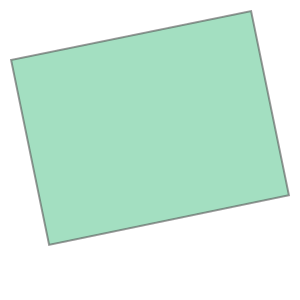

In [176]:
prod_geom

In [18]:
prod.crs()

<Projected CRS: EPSG:32622>
Name: WGS 84 / UTM zone 22N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 54°W and 48°W, northern hemisphere between equator and 84°N, onshore and offshore. Brazil. Canada - Newfoundland. French Guiana. Greenland.
- bounds: (-54.0, 0.0, -48.0, 84.0)
Coordinate Operation:
- name: UTM zone 22N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

CRS projeté en m et non géographique lon/lat

S1_product Attributes : https://eoreader.readthedocs.io/en/v0.17.0/api/eoreader.products.sar.s1_product.S1Product.html

In [5]:
prod.get_raw_band_paths()

{<SarBandNames.VV: 'VV'>: '/vsizip//home/rustt/Documents/IGAST/1_COURS/Teledetection/TP_projet/Data/Tests/zip/S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.zip/S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/measurement/s1b-iw-grd-vv-20170425t214234-20170425t214302-005323-00953e-001.tiff',
 <SarBandNames.VH: 'VH'>: '/vsizip//home/rustt/Documents/IGAST/1_COURS/Teledetection/TP_projet/Data/Tests/zip/S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.zip/S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/measurement/s1b-iw-grd-vh-20170425t214234-20170425t214302-005323-00953e-002.tiff'}

In [6]:
prod.bands


eoreader.SarBand 'VV'
Attributes:
	id: VV
	eoreader_name: VV
	gsd (m): 20.0
	asset_role: intensity
eoreader.SarBand 'VV_DSPK'
Attributes:
	id: VV_DSPK
	eoreader_name: VV_DSPK
	gsd (m): 20.0
	asset_role: intensity
eoreader.SarBand 'VH'
Attributes:
	id: VH
	eoreader_name: VH
	gsd (m): 20.0
	asset_role: intensity
eoreader.SarBand 'VH_DSPK'
Attributes:
	id: VH_DSPK
	eoreader_name: VH_DSPK
	gsd (m): 20.0
	asset_role: intensity

gsd (m): 20.0 ??

band_vh = prod.load(VH)

/home/rustt/miniforge3/envs/otb3.8/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/rustt/miniforge3/envs/otb3.8/lib/python3.8/site-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


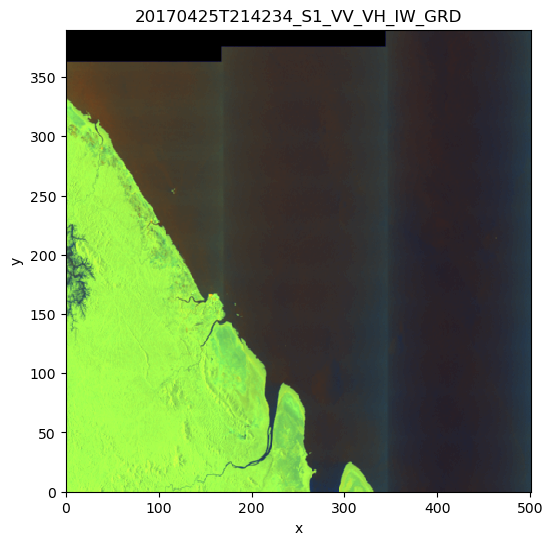

In [16]:
prod.plot()


i

In [48]:
import zipfile

zip = zipfile.ZipFile(raster_path_zip)

# list available files in the container
print (zip.namelist())

['S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-level-1-calibration.xsd', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-level-1-product.xsd', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-object-types.xsd', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-level-1-noise.xsd', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-map-overlay.xsd', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-level-1-quicklook.xsd', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-product-preview.xsd', 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-level-

In [53]:
zip

<zipfile.ZipFile filename='/home/rustt/Documents/Projects/S1_S2_classification/Data/Tests/zip/S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.zip' mode='r'>

In [54]:

with zipfile.ZipFile(raster_path_zip) as zip:
    print("d")
zip

d


<zipfile.ZipFile [closed]>

In [55]:
raster_path_zip

'/home/rustt/Documents/Projects/S1_S2_classification/Data/Tests/zip/S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.zip'

In [49]:
print (zip.infolist())

[<ZipInfo filename='S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/' filemode='drwxr-x---' external_attr=0x10>, <ZipInfo filename='S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/' filemode='drwxr-x---' external_attr=0x10>, <ZipInfo filename='S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-level-1-calibration.xsd' compress_type=deflate filemode='-rw-r-----' file_size=6427 compress_size=1460>, <ZipInfo filename='S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-level-1-product.xsd' compress_type=deflate filemode='-rw-r-----' file_size=147374 compress_size=22388>, <ZipInfo filename='S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/s1-object-types.xsd' compress_type=deflate filemode='-rw-r-----' file_size=62654 compress_size=7424>, <ZipInfo filename='S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/support/

In [50]:
l = zip.namelist()

In [51]:
l = [_ for _ in l if _.endswith((".tif", ".tiff"))]

In [52]:
l

['S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/measurement/s1b-iw-grd-vh-20170425t214234-20170425t214302-005323-00953e-002.tiff',
 'S1B_IW_GRDH_1SDV_20170425T214234_20170425T214302_005323_00953E_F02D.SAFE/measurement/s1b-iw-grd-vv-20170425t214234-20170425t214302-005323-00953e-001.tiff']

In [61]:
with rio.open(raster_path) as src:
    print(src.bounds)

BoundingBox(left=0.0, bottom=19094.0, right=25167.0, top=0.0)
